##### 对shuffle_50k训练数据进行切分，45k用作训练，剩下的用来验证

In [1]:
# start tensorflow interactiveSession                              线上   0.68
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:45000]
vali = data[49000:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 18, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 4096])
b_fc1 = bias_variable([4096])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([4096, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.RMSPropOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
for i in range(30000):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
    train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(temp_loss)
    vali_Eval.append(vali_accuracy)
    train_Eval.append(train_accuracy)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (45000, 18449)
The shape of vali is  (1989, 18449)
step 0, train accuracy 0.078125, vali accuracy 0.0613374, train loss 3554.09
step 200, train accuracy 0.179688, vali accuracy 0.171443, train loss 3342.04
step 400, train accuracy 0.238281, vali accuracy 0.191554, train loss 3112.47
step 600, train accuracy 0.234375, vali accuracy 0.2182, train loss 3127.49
step 800, train accuracy 0.230469, vali accuracy 0.208648, train loss 3103.7
step 1000, train accuracy 0.386719, vali accuracy 0.311212, train loss 2228.68
step 1200, train accuracy 0.472656, vali accuracy 0.397185, train loss 668.577
step 1400, train accuracy 0.503906, vali accuracy 0.438411, train loss 563.911
step 1600, train accuracy 0.558594, vali accuracy 0.490699, train loss 358.859
step 1800, train accuracy 0.539062, vali accuracy 0.499246, train loss 457.887
step 2000, train accuracy 0.601562, vali accuracy 0.519859, train loss 359.756
step 2200, train accuracy 0.628906, vali accuracy 0.536451, train 

step 20800, train accuracy 1, vali accuracy 0.718451, train loss 2.34078
step 21000, train accuracy 0.996094, vali accuracy 0.701357, train loss 11.9652
step 21200, train accuracy 0.996094, vali accuracy 0.711413, train loss 20.9219
step 21400, train accuracy 0.992188, vali accuracy 0.709904, train loss 24.2649
step 21600, train accuracy 0.992188, vali accuracy 0.714932, train loss 19.9634
step 21800, train accuracy 1, vali accuracy 0.713927, train loss 3.06917
step 22000, train accuracy 1, vali accuracy 0.71644, train loss 3.25503
step 22200, train accuracy 0.992188, vali accuracy 0.713424, train loss 34.8738
step 22400, train accuracy 0.992188, vali accuracy 0.712921, train loss 20.5753
step 22600, train accuracy 1, vali accuracy 0.720965, train loss 3.16897
step 22800, train accuracy 1, vali accuracy 0.715938, train loss 3.99126
step 23000, train accuracy 0.992188, vali accuracy 0.724987, train loss 35.2923
step 23200, train accuracy 0.996094, vali accuracy 0.715435, train loss 2.86

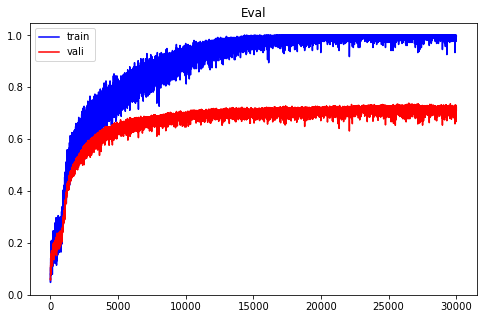

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

In [3]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.55      0.63      0.59       115
          1       0.60      0.50      0.55       107
          2       0.70      0.63      0.66       130
          3       0.55      0.56      0.55       118
          4       0.52      0.40      0.46       141
          5       0.64      0.66      0.65       122
          6       0.87      0.88      0.88       121
          7       0.64      0.70      0.67       136
          8       0.77      0.78      0.77       117
          9       0.39      0.46      0.42        97
         10       0.90      0.90      0.90       108
         11       0.79      0.76      0.78       100
         12       0.89      0.86      0.87       112
         13       0.79      0.81      0.80       114
         14       0.92      0.91      0.91       107
         15       0.84      0.91      0.87       138
         16       0.99      0.98      0.99       106

avg / total       0.72      0.72      0.72  

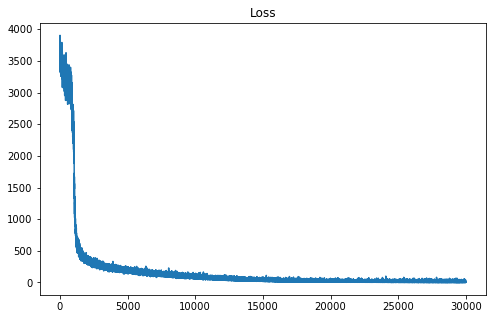

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [1]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s1 = f['sen1']
test_s2 = f['sen2']

test = []
for i in range(0,test_s1.shape[0]):
    temp1 = test_s1[i].flatten()
    temp2 = test_s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    test.append(temp)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

out.to_csv('4_conv_2_fc_RSMProp.csv', index = False, header = False)

NameError: name 'np' is not defined

* 损失函数加入正则化项
* 分类效果并没有提高，说明原先网络结构有待加强
* 但是从学习曲线可以看出正则化项的加入确实减轻了过拟合

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:45000]
vali = data[49000:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 18, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# third convolutional layer
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_pool3 = max_pool_2x2(h_conv3_2)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 8192])
b_fc1 = bias_variable([8192])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc3 = weight_variable([8192, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.RMSPropOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
for i in range(30000):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
    train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(temp_loss)
    vali_Eval.append(vali_accuracy)
    train_Eval.append(train_accuracy)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))


The shape of train is  (45000, 18449)
The shape of vali is  (1989, 18449)
step 0, train accuracy 0.0703125, vali accuracy 0.0553042, train loss 3836.11
step 200, train accuracy 0.0976562, vali accuracy 0.0703871, train loss 3723.28
step 400, train accuracy 0.1875, vali accuracy 0.106083, train loss 3352.56
step 600, train accuracy 0.160156, vali accuracy 0.104072, train loss 3465.39
step 800, train accuracy 0.105469, vali accuracy 0.105581, train loss 3691.04
step 1000, train accuracy 0.0859375, vali accuracy 0.0975365, train loss 3771.63
step 1200, train accuracy 0.0859375, vali accuracy 0.104575, train loss 3771.63


KeyboardInterrupt: 

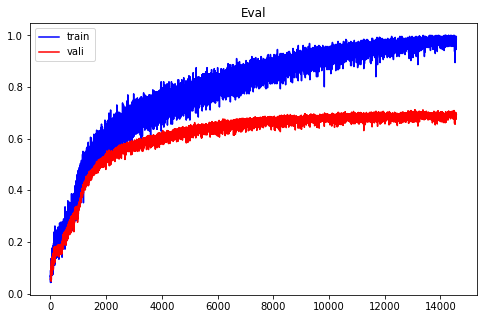

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

In [3]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.47      0.60      0.52       115
          1       0.52      0.42      0.47       107
          2       0.67      0.66      0.66       130
          3       0.50      0.49      0.50       118
          4       0.49      0.48      0.49       141
          5       0.60      0.60      0.60       122
          6       0.86      0.93      0.89       121
          7       0.62      0.70      0.66       136
          8       0.80      0.73      0.76       117
          9       0.38      0.35      0.37        97
         10       0.88      0.91      0.89       108
         11       0.78      0.76      0.77       100
         12       0.91      0.79      0.84       112
         13       0.82      0.81      0.81       114
         14       0.92      0.91      0.91       107
         15       0.87      0.91      0.89       138
         16       0.98      0.98      0.98       106

avg / total       0.71      0.71      0.71  

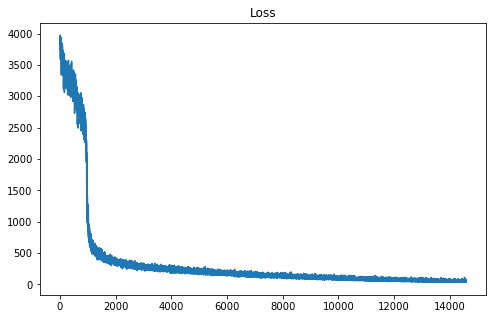

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

##### 4层卷积，3层全连接网络

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:45000]
vali = data[49000:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 18, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


# fc_2
w_fc2 = weight_variable([1024, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)


# readout layer
w_fc3 = weight_variable([2048, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.RMSPropOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
for i in range(30000):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
    train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(temp_loss)
    vali_Eval.append(vali_accuracy)
    train_Eval.append(train_accuracy)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (45000, 18449)
The shape of vali is  (1989, 18449)
step 0, train accuracy 0.0820312, vali accuracy 0.089995, train loss 3726.43
step 200, train accuracy 0.125, vali accuracy 0.111111, train loss 3605.3
step 400, train accuracy 0.117188, vali accuracy 0.122675, train loss 3602.09
step 600, train accuracy 0.179688, vali accuracy 0.163901, train loss 3381.07
step 800, train accuracy 0.21875, vali accuracy 0.204625, train loss 3223.62
step 1000, train accuracy 0.210938, vali accuracy 0.210156, train loss 3248.79
step 1200, train accuracy 0.203125, vali accuracy 0.212167, train loss 3288.09
step 1400, train accuracy 0.207031, vali accuracy 0.225239, train loss 3270.18
step 1600, train accuracy 0.207031, vali accuracy 0.241327, train loss 3271.97
step 1800, train accuracy 0.222656, vali accuracy 0.240825, train loss 3200.93
step 2000, train accuracy 0.332031, vali accuracy 0.27099, train loss 2718.29
step 2200, train accuracy 0.257812, vali accuracy 0.262946, train los

step 20600, train accuracy 0.855469, vali accuracy 0.71644, train loss 129.682
step 20800, train accuracy 0.8125, vali accuracy 0.70538, train loss 139.221
step 21000, train accuracy 0.808594, vali accuracy 0.70538, train loss 148.621
step 21200, train accuracy 0.816406, vali accuracy 0.700352, train loss 130.48
step 21400, train accuracy 0.828125, vali accuracy 0.720463, train loss 135.42
step 21600, train accuracy 0.808594, vali accuracy 0.714932, train loss 137.137
step 21800, train accuracy 0.824219, vali accuracy 0.699346, train loss 152.853
step 22000, train accuracy 0.820312, vali accuracy 0.714932, train loss 147.408
step 22200, train accuracy 0.839844, vali accuracy 0.711916, train loss 125.075
step 22400, train accuracy 0.824219, vali accuracy 0.722474, train loss 137.936
step 22600, train accuracy 0.839844, vali accuracy 0.723982, train loss 128.514
step 22800, train accuracy 0.855469, vali accuracy 0.718954, train loss 121.203
step 23000, train accuracy 0.816406, vali accur

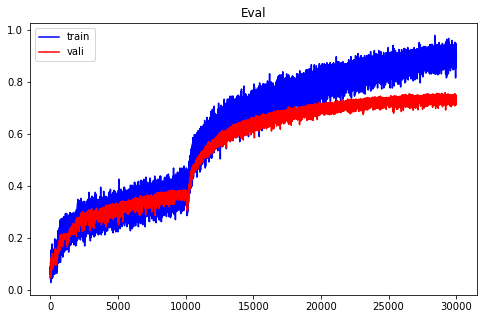

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

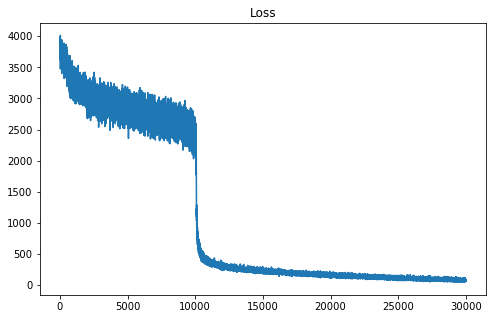

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.60      0.62      0.61       115
          1       0.57      0.53      0.55       107
          2       0.67      0.72      0.69       130
          3       0.51      0.69      0.59       118
          4       0.64      0.50      0.56       141
          5       0.70      0.66      0.68       122
          6       0.82      0.88      0.85       121
          7       0.73      0.73      0.73       136
          8       0.79      0.75      0.77       117
          9       0.46      0.42      0.44        97
         10       0.96      0.84      0.90       108
         11       0.76      0.86      0.81       100
         12       0.83      0.80      0.82       112
         13       0.84      0.79      0.81       114
         14       0.88      0.93      0.90       107
         15       0.85      0.84      0.84       138
         16       0.97      0.98      0.98       106

avg / total       0.74      0.74      0.74  

##### 5层卷积，3层全连接网络

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 2048])
b_fc1 = bias_variable([2048])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([2048, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([2048, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
learning_rate = 1e-4
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+tf.norm(w_fc3)
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 1000000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0654297, vali accuracy 0.0537959, train loss 15425
step 200, train accuracy 0.206055, vali accuracy 0.174962, train loss 13049.3
step 400, train accuracy 0.251953, vali accuracy 0.256913, train loss 12208
step 600, train accuracy 0.460938, vali accuracy 0.427853, train loss 1793.86
step 800, train accuracy 0.594727, vali accuracy 0.555556, train loss 1221.65
step 1000, train accuracy 0.650391, vali accuracy 0.600302, train loss 1069.49
step 1200, train accuracy 0.697266, vali accuracy 0.639015, train loss 941.073
step 1400, train accuracy 0.685547, vali accuracy 0.663147, train loss 927.293
step 1600, train accuracy 0.728516, vali accuracy 0.68175, train loss 797.668
step 1800, train accuracy 0.733398, vali accuracy 0.693313, train loss 805.501
step 2000, train accuracy 0.74707, vali accuracy 0.707893, train loss 779.102
step 2200, train accuracy 0.746094, vali accuracy 0.721468, train lo

KeyboardInterrupt: 

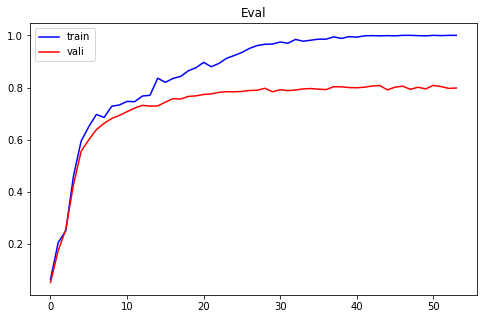

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

In [3]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.70      0.68      0.69       115
          1       0.74      0.70      0.72       107
          2       0.75      0.71      0.73       130
          3       0.69      0.69      0.69       118
          4       0.59      0.50      0.54       141
          5       0.68      0.75      0.71       122
          6       0.85      0.93      0.89       121
          7       0.81      0.81      0.81       136
          8       0.84      0.85      0.84       117
          9       0.59      0.69      0.64        97
         10       0.91      0.94      0.93       108
         11       0.87      0.87      0.87       100
         12       0.93      0.85      0.89       112
         13       0.88      0.91      0.90       114
         14       0.90      0.95      0.93       107
         15       0.91      0.90      0.91       138
         16       0.99      0.99      0.99       106

avg / total       0.80      0.80      0.80  

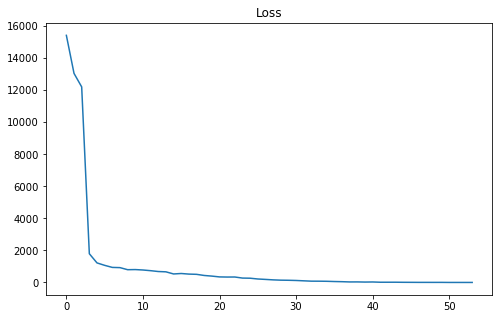

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

##### 损失函数加入正则化项

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 2048])
b_fc1 = bias_variable([2048])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([2048, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([2048, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-1
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+tf.norm(w_conv1_1)+tf.norm(w_conv1_2)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0449219, vali accuracy 0.0542986, train loss 15827.3
step 200, train accuracy 0.149414, vali accuracy 0.155354, train loss 14098
step 400, train accuracy 0.176758, vali accuracy 0.200603, train loss 13634
step 600, train accuracy 0.212891, vali accuracy 0.207139, train loss 13017.2
step 800, train accuracy 0.233398, vali accuracy 0.216692, train loss 12656.5
step 1000, train accuracy 0.249023, vali accuracy 0.244344, train loss 12281.7
step 1200, train accuracy 0.526367, vali accuracy 0.497235, train loss 1498.18
step 1400, train accuracy 0.599609, vali accuracy 0.59276, train loss 1271.34
step 1600, train accuracy 0.677734, vali accuracy 0.626948, train loss 983.512
step 1800, train accuracy 0.698242, vali accuracy 0.656611, train loss 945.65
step 2000, train accuracy 0.709961, vali accuracy 0.682755, train loss 940.552
step 2200, train accuracy 0.724609, vali accuracy 0.707391, train lo

KeyboardInterrupt: 

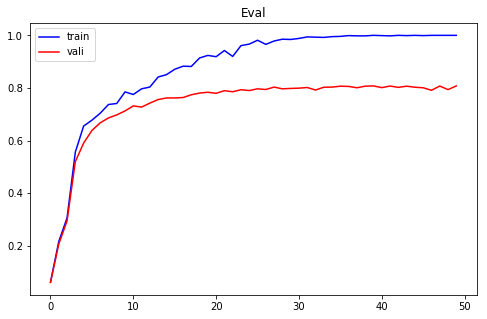

In [2]:
############## gamma == 1e-3 #################
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

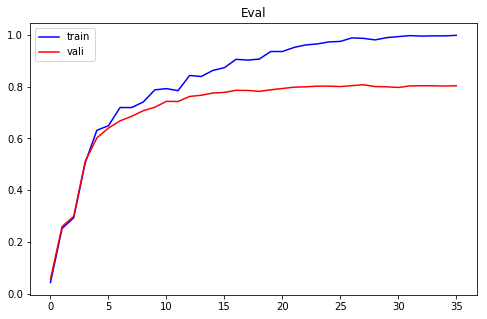

In [2]:
############## gamma == 1e-2 #################
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

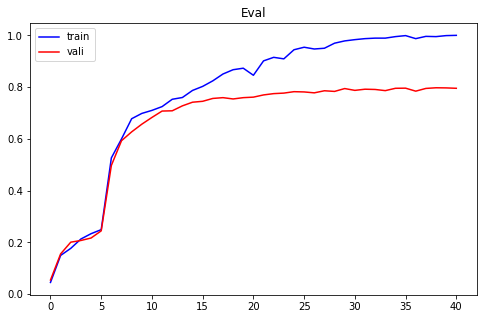

In [2]:
############## gamma == 1e-1 #################
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

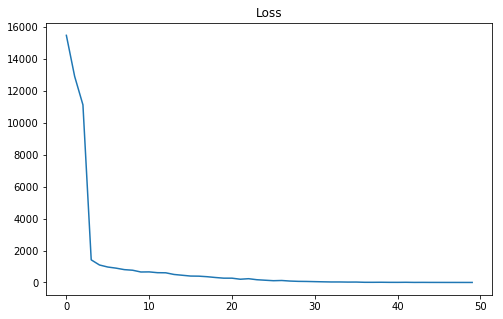

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
############## gamma == 1e-3 #################
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.71      0.72      0.72       115
          1       0.73      0.64      0.69       107
          2       0.69      0.76      0.72       130
          3       0.71      0.67      0.69       118
          4       0.58      0.57      0.57       141
          5       0.65      0.73      0.69       122
          6       0.97      0.85      0.91       121
          7       0.78      0.82      0.80       136
          8       0.82      0.80      0.81       117
          9       0.66      0.69      0.68        97
         10       0.92      0.93      0.92       108
         11       0.82      0.89      0.85       100
         12       0.91      0.84      0.87       112
         13       0.94      0.89      0.91       114
         14       0.93      0.95      0.94       107
         15       0.93      0.91      0.92       138
         16       0.99      0.99      0.99       106

avg / total       0.80      0.80      0.80  

In [3]:
############## gamma == 1e-2 #################
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.77      0.71      0.74       115
          1       0.73      0.69      0.71       107
          2       0.82      0.73      0.77       130
          3       0.71      0.61      0.65       118
          4       0.56      0.56      0.56       141
          5       0.68      0.72      0.70       122
          6       0.90      0.92      0.91       121
          7       0.76      0.87      0.81       136
          8       0.80      0.79      0.80       117
          9       0.63      0.68      0.66        97
         10       0.91      0.91      0.91       108
         11       0.78      0.83      0.81       100
         12       0.95      0.85      0.90       112
         13       0.91      0.93      0.92       114
         14       0.91      0.96      0.94       107
         15       0.92      0.97      0.94       138
         16       1.00      0.99      1.00       106

avg / total       0.81      0.81      0.80  

In [3]:
############## gamma == 1e-1 #################
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.73      0.71      0.72       115
          1       0.66      0.75      0.70       107
          2       0.76      0.72      0.74       130
          3       0.72      0.67      0.69       118
          4       0.63      0.48      0.55       141
          5       0.64      0.71      0.67       122
          6       0.90      0.91      0.91       121
          7       0.77      0.82      0.80       136
          8       0.83      0.79      0.81       117
          9       0.59      0.63      0.61        97
         10       0.94      0.95      0.95       108
         11       0.84      0.84      0.84       100
         12       0.90      0.85      0.88       112
         13       0.88      0.91      0.90       114
         14       0.90      0.96      0.93       107
         15       0.92      0.95      0.93       138
         16       0.99      0.98      0.99       106

avg / total       0.80      0.80      0.80  

##### 4卷积+4全连接

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# fc_3
w_fc3 = weight_variable([1024, 1024])
b_fc3 = bias_variable([1024])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# dropout
h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

# readout layer
w_fc4 = weight_variable([1024, 17])
b_fc4 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc3_drop, w_fc4) + b_fc4)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc4)+tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)
                 +tf.norm(w_conv1_1)+tf.norm(w_conv1_2)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 15000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0498047, vali accuracy 0.0487682, train loss 15271.2
step 200, train accuracy 0.110352, vali accuracy 0.133233, train loss 14528.6
step 400, train accuracy 0.198242, vali accuracy 0.206134, train loss 13183.5
step 600, train accuracy 0.271484, vali accuracy 0.286073, train loss 11907.4
step 800, train accuracy 0.326172, vali accuracy 0.309703, train loss 10927.4
step 1000, train accuracy 0.417969, vali accuracy 0.414279, train loss 1786.18
step 1200, train accuracy 0.544922, vali accuracy 0.503771, train loss 1353.77
step 1400, train accuracy 0.5625, vali accuracy 0.558069, train loss 1296.2
step 1600, train accuracy 0.605469, vali accuracy 0.569633, train loss 1167.7
step 1800, train accuracy 0.662109, vali accuracy 0.603318, train loss 1057.61
step 2000, train accuracy 0.651367, vali accuracy 0.610357, train loss 1055.84
step 2200, train accuracy 0.660156, vali accuracy 0.637506, train 

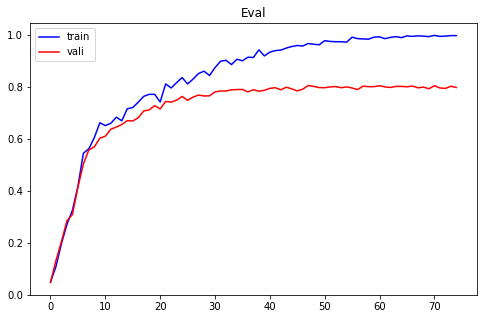

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

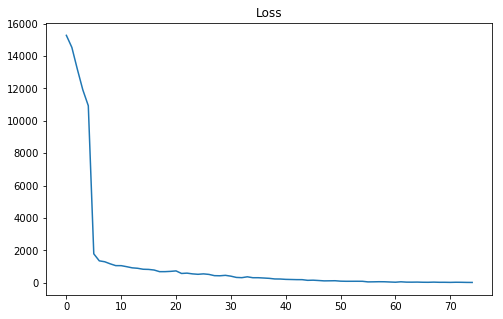

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.75      0.72      0.73       115
          1       0.69      0.72      0.70       107
          2       0.78      0.74      0.76       130
          3       0.66      0.72      0.69       118
          4       0.65      0.52      0.58       141
          5       0.65      0.74      0.69       122
          6       0.92      0.92      0.92       121
          7       0.76      0.77      0.76       136
          8       0.86      0.78      0.82       117
          9       0.59      0.57      0.58        97
         10       0.96      0.94      0.95       108
         11       0.78      0.87      0.82       100
         12       0.90      0.83      0.87       112
         13       0.89      0.90      0.90       114
         14       0.86      0.96      0.91       107
         15       0.91      0.93      0.92       138
         16       1.00      1.00      1.00       106

avg / total       0.80      0.80      0.80  